In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from random import randint as r_int, getrandbits, shuffle

#Encoding and decoding of characters and indexes
chars = "0123456789.=+-*"[:]
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


## Create data
block_size = 24

#Generates 
def build_data(examples:int, digits = 6, doShuffle = True):
  data = []
  X,Y =[], []

  for i in range(examples):
    a, b = r_int(0, 10**digits), r_int(0, 10**digits)
    a_negative, b_negative = bool(getrandbits(1)), bool(getrandbits(1))
    c = (-a if a_negative else a) + (-b if b_negative else b)
    x = ("-" if a_negative else "") + str(a)[::-1] + ("-" if b_negative else "+") + str(b)[::-1] + "="
    y = ("-" if c < 0 else "") + str(abs(c))[::-1] + "."
    data.append([x,y])

  for x,y in data:
    context = (block_size - len(x)) * [10] + [stoi[ix] for ix in x]
    for char in y:
      iy = stoi[char]
      X.append(context)
      Y.append(iy)
      context = context[1:] + [iy]

  combined = list(zip(X, Y))
  if doShuffle:
    shuffle(combined)
  X, Y = zip(*combined)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y



In [2]:
## Choosing NN, loss_fn
# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

#NN class
class num_LM(nn.Module):

    def __init__(self, activation_layers):
        super().__init__()
        
        #Embeding
        self.embeding = nn.Embedding(vocab_size, n_embd)
        
        #Linear and tanh layers
        layers = [nn.Linear(n_embd*block_size, n_hidden,False), nn.Tanh()]        
        for i in range(activation_layers-1):
            layers.append(nn.Linear(n_hidden, n_hidden, False))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(n_hidden, vocab_size,False))
        
        self.layers = nn.ParameterList(layers)
        
    def forward(self, x):
        #Embeding
        batch_size = x.shape[0]
        x = self.embeding(x).view(batch_size,-1)
        
        #Linear and tanh layers
        for layer in self.layers:
            x = layer(x)
            
        return x
        
    def save(self, model_path):
        torch.save(model.state_dict(), model_path)

    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        
model = num_LM(4) #Number of activation layers
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-08)

In [3]:
#generate new batch for each epoch to reduce overfitting, can be turned off
replace_batches = True

if replace_batches:
    Xtr, Ytr = None, None #needs to be defined
else:
    Xtr, Ytr = build_data(200_000)
    
Xte, Yte = build_data(10_000)

In [4]:
## Training NN
# same optimization as last time
max_steps = 25_000
interval = 2_500
batch_size = 32
lossi = []



for i in range(max_steps+1):
    # minibatch construct
    if replace_batches: #new batch each epoch
        Xb, Yb = build_data(batch_size, doShuffle=False)
    else: #generate batches from earlier generated dataset
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    y_pred = model(Xb)
    optimizer.zero_grad()
    loss = loss_fn(y_pred, Yb) # loss function
    loss.backward()
    optimizer.step()

    # track stats
    if i == 0:
            print(f'{i:7d}/{max_steps//1000:3d}k, Initiation loss:{loss.item():.4f}')
            roll_loss = loss.item()
        
    if (i) % interval == 0 and i != 0:
            #Rolling loss is less fluctuacting than batch loss and helps indicate real progress instead of lucky batch
            print(f'{i//1000:7d}k/{max_steps//1000:3d}k, Batch:{loss.item():.4f}, Rolling:{roll_loss:.4f}') 
            
    roll_loss = roll_loss * 0.995 + loss.item() * 0.005
    lossi.append(loss.item())
lossi.pop()

      0/ 25k, Initiation loss:2.7189
      2k/ 25k, Batch:1.8064, Rolling:1.7608
      5k/ 25k, Batch:0.8932, Rolling:0.9409
      7k/ 25k, Batch:0.5219, Rolling:0.4867
     10k/ 25k, Batch:0.4203, Rolling:0.3856
     12k/ 25k, Batch:0.3789, Rolling:0.3520
     15k/ 25k, Batch:0.4861, Rolling:0.3378
     17k/ 25k, Batch:0.4569, Rolling:0.3279
     20k/ 25k, Batch:0.4891, Rolling:0.3252
     22k/ 25k, Batch:0.2434, Rolling:0.3218
     25k/ 25k, Batch:0.1908, Rolling:0.3020


0.19080732762813568

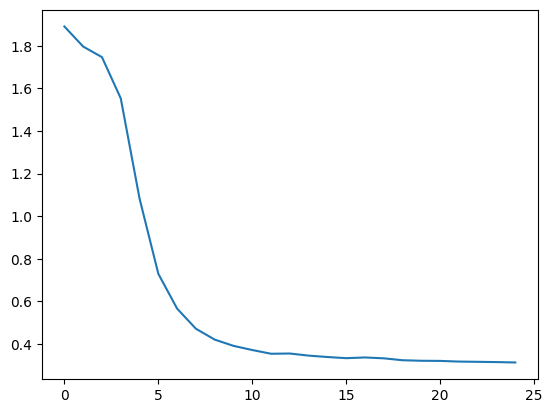

In [5]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.show()

In [27]:
## Visualisations, evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    #'train': (Xtr, Ytr),
    'test': (Xte, Yte),
  }[split]
  loss = loss_fn(y_pred, Yb) # loss function
  print(split, loss)

split_loss('test')

## Output testing
X_check, Y_check = build_data(100)

for i in range(1):
    context = X_check[i].tolist()
    out = context
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 10:
        break
    
    out = ''.join(itos[i] for i in out) # decode and print the generated word
    out = out.replace(".","")
    print(out)
    separator = []
    j = 0
    for i in out:
      if i in "+-=":
        separator.append(i)
        j += 1
        separator.append("")
      else:
        separator[j] = "".join(separator[j], i)
    for i in range(j+1):
      separator[i] = separator[i][::-1]
    
print(out)

test tensor(0.1908)
-443136+521566=18733


TypeError: str.join() takes exactly one argument (2 given)